 # Google Thesios Data Analysis

## Overview  
Data analysis on google thesios data released on 27 April 2024.  
Know more about the Thesios from https://github.com/google-research-datasets/thesios

----------------------------------------------------------------------------------
**Total clusters**: 3  
**Trace duration**: 60 days  

## Data Categories  
**IO Zone**: WARM, COLD, UNKNOWN  
**Operation Type**: READ, WRITE  
**Service Class (Request Priority)**: LATENCY_SENSITIVE, THROUGHPUT_ORIENTED, OTHER  
**Flash Cache**: From flash cache: 0 or 1  
**Cache Hit**: Hit[1], Miss[0], Write[-1 or n/a]  


## Traces Analysis

In this section, we have a bunch of helper methods such as download data from GCS and load to dataframe, convert IO size from bytes, convert IO size to bytes, etc. 

In [1]:
!pip3 install pandas
!pip3 install pandas matplotlib
!pip3 install google-cloud-storage
!pip3 install pyarrow
!pip3 install anytree

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from google.cloud import storage
import os
import random
import requests
import pandas as pd
import concurrent.futures
from collections import defaultdict
import math
from anytree import Node, RenderTree
from collections import defaultdict, Counter
import matplotlib.pyplot as plt


In [3]:
def list_bucket_contents(bucket_name, prefix=""):
    """Lists all blobs in the bucket with the given prefix."""
    storage_client = storage.Client.create_anonymous_client()
    return list(storage_client.list_blobs(bucket_name, prefix=prefix))

def group_by_immediate_subfolder(blobs, parent_folder):
    """Groups blobs by their immediate subfolder within the specified parent folder."""
    subfolders = defaultdict(list)
    parent_prefix = parent_folder.rstrip('/') + '/'
    for blob in blobs:
        if blob.name.startswith(parent_prefix):
            relative_path = blob.name[len(parent_prefix):]
            subfolder = relative_path.split('/')[0]
            if '/' in relative_path:  # This ensures we're only looking at files within subfolders
                subfolders[subfolder].append(blob)
    return subfolders

def download_file(url, destination_path):
    """Downloads a single file from a given URL."""
    response = requests.get(url)
    if response.status_code == 200:
        with open(destination_path, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded {url} to {destination_path}")
        return destination_path
    else:
        print(f"Failed to download {url}")
        return None

def random_download_files(bucket_name, parent_folder, num_files=3):
    """Randomly downloads a specified number of files from each immediate subfolder of the parent folder."""
    blobs = list_bucket_contents(bucket_name, parent_folder)
    subfolders = group_by_immediate_subfolder(blobs, parent_folder)
    
    base_url = f"https://storage.googleapis.com/{bucket_name}/"
    current_dir = os.getcwd()
    download_dir = os.path.join(current_dir, "downloaded_files")
    os.makedirs(download_dir, exist_ok=True)
    
    downloaded_files = []
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        future_to_url = {}
        for subfolder, subfolder_blobs in subfolders.items():
            selected_blobs = random.sample(subfolder_blobs, min(num_files, len(subfolder_blobs)))
            for blob in selected_blobs:
                url = base_url + blob.name
                new_filename = f"{subfolder}-{os.path.basename(blob.name)}"
                destination_path = os.path.join(download_dir, new_filename)
                future = executor.submit(download_file, url, destination_path)
                future_to_url[future] = (url, destination_path)
        
        for future in concurrent.futures.as_completed(future_to_url):
            url, destination_path = future_to_url[future]
            try:
                downloaded_path = future.result()
                if downloaded_path:
                    downloaded_files.append(downloaded_path)
            except Exception as exc:
                print(f"{url} generated an exception: {exc}")
    
    return downloaded_files

def load_files_to_dataframe(file_paths):
    """Loads multiple CSV files into a single DataFrame, dropping specified columns."""
    dataframes = []
    columns_to_drop = ['filename', 'file_offset', 'application', 'c_time', 'start_time', 'disk_time', 'simulated_disk_start_time', 'simulated_latency']
    
    for file_path in file_paths:
        # Read only the columns we want to keep
        df = pd.read_csv(file_path, usecols=lambda x: x not in columns_to_drop)
        dataframes.append(df)
        os.remove(file_path)
    
    return pd.concat(dataframes, ignore_index=True)

def nearest_power_of_2(n):
    """
    Returns the nearest power of 2 that is greater than or equal to n.
    """
    if n == 0:
        return 0
    return 1 << (n - 1).bit_length()

def convert_size(size_bytes):
    """
    Convert size in bytes to KB or MB for improved readability, rounding down to the nearest integer.
    """
    # If the value is already formatted, return it as is
    if isinstance(size_bytes, str):
        return size_bytes
    
    kb = 1024
    mb = kb * 1024
    
    if size_bytes < kb:
        return f"{size_bytes} B"
    elif size_bytes < mb:
        return f"{size_bytes // kb} KB"
    else:
        return f"{size_bytes // mb} MB"


def size_to_bytes(size_str):
    """Convert a size string to bytes."""
    units = {'B': 1, 'KB': 1024, 'MB': 1024**2, 'GB': 1024**3}
    number, unit = size_str.split()
    return int(float(number) * units[unit.upper()])



# Function to analyze and print distribution
def analyze_distribution(column, name):
    counts = thesios_df[column].value_counts()
    total = len(thesios_df)
    print(f"\n{name} Distribution:")
    for value, count in counts.items():
        percentage = (count / total) * 100
        print(f"{value}: {count} ({percentage:.2f}%)")

# Function to analyze I/O sizes
def analyze_io_size(column, name):
    sizes = thesios_df[column]
    print(f"\n{name} Analysis:")
    
    print(f"Distinct sizes: {sizes.nunique()}")
    print(f"Lowest size: {sizes.min()} bytes ({convert_size(sizes.min())})")
    print(f"Highest size: {sizes.max()} bytes ({convert_size(sizes.max())})")
    

# Function to identify potential biases
def identify_biases(node, threshold=50):
    if node.is_leaf:
        size, count_info = node.name.split(': ')
        count, percentage = count_info.split(' ')
        percentage = float(percentage[1:-2])  # Remove parentheses and % sign
        if percentage > threshold:
            print(f"Potential bias detected: {node.parent.parent.parent.name} - {node.parent.parent.name} - {node.parent.name} - {node.name}")



def request_size_distribution_by_op_type(df):
    size_order = ['0B', '512B', '4KB', '64KB', '512KB', '1MB', '8MB']
    
    grouped = df.groupby('op_type')['request_io_size_bucket'].apply(list)
    
    results = {}
    total_ops = 0
    for op_type, buckets in grouped.items():
        bucket_counts = Counter(buckets)
        total_count = len(buckets)
        total_ops += total_count
        
        distribution = {
            bucket: {
                'count': bucket_counts.get(bucket, 0),
                'percentage': (bucket_counts.get(bucket, 0) / total_count) * 100
            }
            for bucket in size_order
        }
        
        results[op_type] = {
            'distribution': distribution,
            'total_count': total_count
        }
    
    for op_type, data in results.items():
        data['overall_percentage'] = (data['total_count'] / total_ops) * 100
    
    return results



### Load dataframe

In [4]:
if __name__ == "__main__":
   
    # Get the present working directory
    pwd = os.getcwd()
    
    # Check if 'thesios_data.csv' exists in the PWD
    file_name = "thesios_data.csv"
    file_path = os.path.join(pwd, file_name)
    
    if os.path.isfile(file_path):
        print(f"'{file_name}' exists in the current directory.")
        columns_to_drop = ['filename', 'file_offset', 'application', 'c_time', 'start_time', 'disk_time', 'simulated_disk_start_time', 'simulated_latency']
        thesios_df = pd.read_csv(file_path, usecols=lambda x: x not in columns_to_drop)
    else:
        print(f"'{file_name}' not found in the current directory.")
        bucket_name = "thesios-io-traces"
        parent_folder = "cluster1_16TB/"  # The parent folder
        files_per_subfolder = 1

         # Download files
        downloaded_files = random_download_files(bucket_name, parent_folder, files_per_subfolder)

        thesios_df = load_files_to_dataframe(downloaded_files)
        # Save the combined DataFrame to a CSV file
        thesios_df.to_csv("thesios_data.csv", index=False)

        print(f"Downloaded and loaded {len(downloaded_files)} files into a DataFrame.")


'thesios_data.csv' exists in the current directory.


### Thesios dataframe information

In [5]:
thesios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90845332 entries, 0 to 90845331
Data columns (total 9 columns):
 #   Column                  Dtype 
---  ------                  ----- 
 0   io_zone                 object
 1   redundancy_type         object
 2   op_type                 object
 3   service_class           object
 4   from_flash_cache        int64 
 5   cache_hit               int64 
 6   request_io_size_bytes   int64 
 7   disk_io_size_bytes      int64 
 8   response_io_size_bytes  int64 
dtypes: int64(5), object(4)
memory usage: 6.1+ GB


## Data spread by each attribute

In [6]:
analyze_distribution('io_zone', 'IO Zone')
analyze_distribution('op_type', 'Operation Type')
analyze_distribution('service_class', 'Service Class')
analyze_distribution('from_flash_cache', 'From Flash Cache')
analyze_distribution('cache_hit', 'Cache Hit')

analyze_io_size('request_io_size_bytes', 'Request I/O Size')
analyze_io_size('response_io_size_bytes', 'Response I/O Size')
analyze_io_size('disk_io_size_bytes', 'Disk I/O Size')


IO Zone Distribution:
WARM: 87918924 (96.78%)
COLD: 2904404 (3.20%)
UNKNOWN: 22004 (0.02%)

Operation Type Distribution:
WRITE: 52280233 (57.55%)
READ: 38565099 (42.45%)

Service Class Distribution:
THROUGHPUT_ORIENTED: 63966447 (70.41%)
LATENCY_SENSITIVE: 23789331 (26.19%)
OTHER: 3089554 (3.40%)

From Flash Cache Distribution:
0: 84316987 (92.81%)
1: 6528345 (7.19%)

Cache Hit Distribution:
-1: 52280233 (57.55%)
0: 23063154 (25.39%)
1: 15501945 (17.06%)

Request I/O Size Analysis:
Distinct sizes: 1041974
Lowest size: 0 bytes (0 B)
Highest size: 8404992 bytes (8 MB)

Response I/O Size Analysis:
Distinct sizes: 216731
Lowest size: 0 bytes (0 B)
Highest size: 8404992 bytes (8 MB)

Disk I/O Size Analysis:
Distinct sizes: 1014690
Lowest size: 0 bytes (0 B)
Highest size: 8679424 bytes (8 MB)


### The sizes in request_io_size_bytes are represented in bytes. For simplicity and our understanding, let's group them to the nearest of the following sizes. 
[0 B, 512 B, 4KB, 64 KB, 512 KB, 1 MB, 8 MB]

In [7]:
import pandas as pd
import numpy as np

# Define the bucket sizes in bytes
BUCKET_SIZES = {
    '0B': 0,
    '512B': 512,
    '4KB': 4 * 1024,
    '64KB': 64 * 1024,
    '512KB': 512 * 1024,
    '1MB': 1024 * 1024,
    '8MB': 8 * 1024 * 1024
}

def map_to_nearest_bucket(size):
    """
    Map a given size to the nearest bucket size.
    """
    bucket_values = list(BUCKET_SIZES.values())
    nearest_value = min(bucket_values, key=lambda x: abs(x - size))
    return next(name for name, value in BUCKET_SIZES.items() if value == nearest_value)

thesios_df['request_io_size_bucket'] = thesios_df['request_io_size_bytes'].apply(map_to_nearest_bucket)


## Lets look at sample data from dataframe

In [8]:
thesios_df.head(20)

,io_zone,redundancy_type,op_type,service_class,from_flash_cache,cache_hit,request_io_size_bytes,disk_io_size_bytes,response_io_size_bytes,request_io_size_bucket
0,WARM,REPLICATED,READ,THROUGHPUT_ORIENTED,0,1,377568,0,0,512KB
1,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,2976,2976,0,4KB
2,WARM,REPLICATED,READ,THROUGHPUT_ORIENTED,0,1,32832,0,0,4KB
3,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,1438,1438,0,512B
4,WARM,REPLICATED,WRITE,LATENCY_SENSITIVE,0,-1,21228,21228,0,4KB
5,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,5374,5374,0,4KB
6,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,1606,1606,0,512B
7,WARM,REPLICATED,READ,THROUGHPUT_ORIENTED,0,0,49248,53248,49248,64KB
8,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,773,773,0,512B
9,WARM,REPLICATED,WRITE,THROUGHPUT_ORIENTED,0,-1,1511,1511,0,512B


## Note that there are requests with IO size of 0 bytes. 

In [9]:
df_zero_kb = thesios_df[thesios_df['request_io_size_bytes'] == 0]
for attribute in df_zero_kb.columns:
    print("Field: {} ".format(attribute))
    print("Unique values: {}".format(df_zero_kb[attribute].unique()))
    print("Length: {}".format(len(df_zero_kb[attribute].unique())),"\n")


Field: io_zone 
Unique values: ['WARM' 'COLD' 'UNKNOWN']
Length: 3 

Field: redundancy_type 
Unique values: ['ERASURE_CODED' 'REPLICATED']
Length: 2 

Field: op_type 
Unique values: ['WRITE']
Length: 1 

Field: service_class 
Unique values: ['LATENCY_SENSITIVE' 'THROUGHPUT_ORIENTED' 'OTHER']
Length: 3 

Field: from_flash_cache 
Unique values: [0]
Length: 1 

Field: cache_hit 
Unique values: [-1]
Length: 1 

Field: request_io_size_bytes 
Unique values: [0]
Length: 1 

Field: disk_io_size_bytes 
Unique values: [0]
Length: 1 

Field: response_io_size_bytes 
Unique values: [0]
Length: 1 

Field: request_io_size_bucket 
Unique values: ['0B']
Length: 1 



### Surprisingly, 0 bytes requests are only on WRITE service type. Lets see what percentage of overall data has 0 byte requests

In [10]:
# Calculating the percentage of rows in df_zero_kb compared to thesios_df
zero_kb_count = df_zero_kb.shape[0]
thesios_df_count = thesios_df.shape[0]

percentage_zero_kb = (zero_kb_count / thesios_df_count) * 100

print(f"Percentage of df_zero_kb in thesios_df: {percentage_zero_kb:.2f}%")


Percentage of df_zero_kb in thesios_df: 15.58%


### Analyse requests spread

#### Lets analyse by grouping based on service_class (LATENCY_SENSITIVE/THROUGHPUT_ORIENTED). 

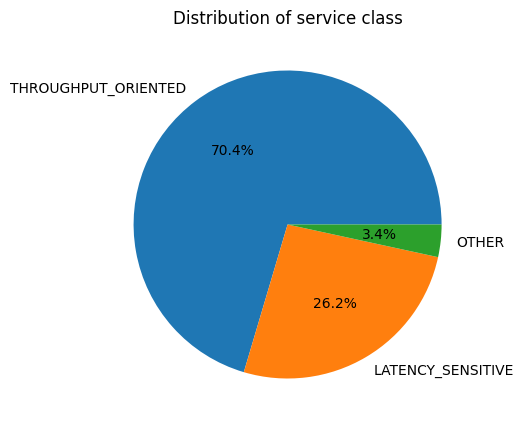

In [11]:

# 1. Overall distribution of throughput vs latency tests
plt.figure(figsize=(5, 5))
thesios_df['service_class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of service class')
plt.ylabel('')
plt.show()

#### Let's analyse READ/WRITE distribution for each service_class

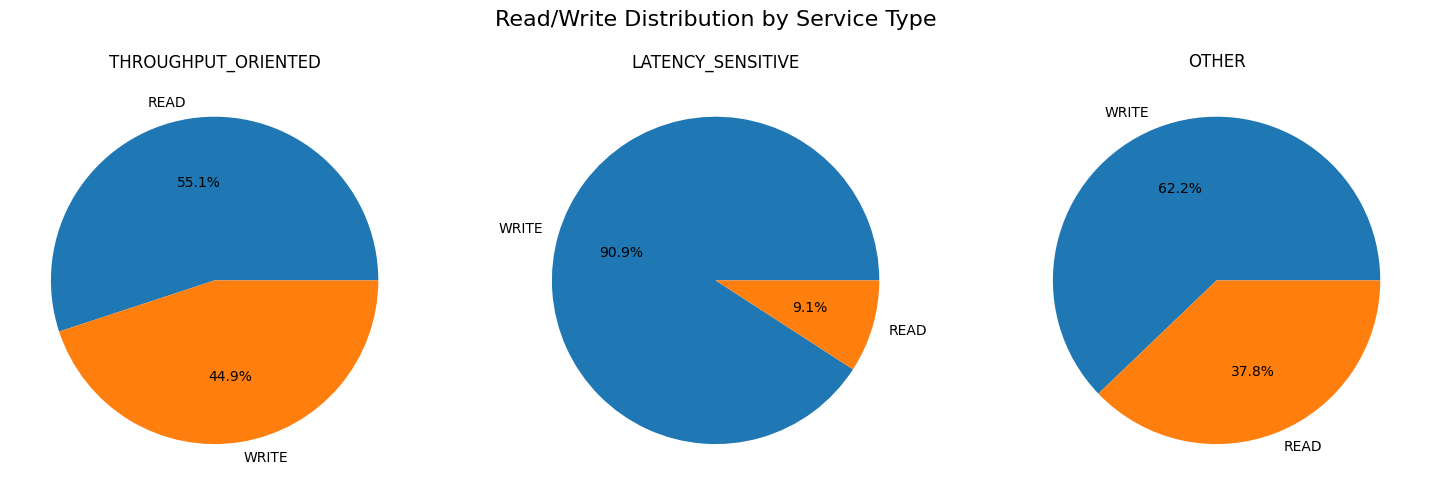

In [12]:
service_types = thesios_df['service_class'].unique()

fig, axes = plt.subplots(1, len(service_types), figsize=(15, 5))  # 1 row, N columns

for i, service_type in enumerate(service_types):
    service_df = thesios_df[thesios_df['service_class'] == service_type]
    
    service_df['op_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i])
    
    axes[i].set_title(service_type)
    axes[i].set_ylabel('')  # Remove y-axis labels for clarity

fig.suptitle('Read/Write Distribution by Service Type', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [13]:
from anytree import Node, RenderTree
from collections import Counter

def op_type_create_request_size_tree_with_counts(df):
    root = Node("Request Size Buckets")
    
    # Group the data
    grouped = df.groupby(['op_type', 'service_class', 'from_flash_cache', 'cache_hit'])
    
    for (op_type, service_class, from_flash, cache_hit), group in grouped:
        # Create nodes for each level
        op_node = Node(op_type, parent=root)
        service_node = Node(service_class, parent=op_node)
        flash_node = Node(f"Flash: {from_flash}", parent=service_node)
        cache_node = Node(f"Cache: {cache_hit}", parent=flash_node)
        
        # Count occurrences of each request size bucket
        size_counts = Counter(group['request_io_size_bucket'])
        
        # Sort sizes by count
        sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Calculate total count for this category
        total_count = sum(size_counts.values())
        
        # Add sizes as leaf nodes with count and percentage
        for size, count in sorted_sizes:
            percentage = (count / total_count) * 100
            Node(f"{size}: {count} ({percentage:.2f}%)", parent=cache_node)
        
        # Add total count to the cache_hit node
        cache_node.name += f" (Total: {total_count})"
    
    return root

# Assuming thesios_df is your DataFrame
root = op_type_create_request_size_tree_with_counts(thesios_df)

# Print the tree
for pre, _, node in RenderTree(root):
    print(f"{pre}{node.name}")

Request Size Buckets
├── READ
│   └── LATENCY_SENSITIVE
│       └── Flash: 0
│           └── Cache: 0 (Total: 1404819)
│               ├── 1MB: 475124 (33.82%)
│               ├── 64KB: 398343 (28.36%)
│               ├── 512KB: 311127 (22.15%)
│               ├── 4KB: 205541 (14.63%)
│               ├── 8MB: 10029 (0.71%)
│               ├── 512B: 3923 (0.28%)
│               └── 0B: 732 (0.05%)
├── READ
│   └── LATENCY_SENSITIVE
│       └── Flash: 0
│           └── Cache: 1 (Total: 771368)
│               ├── 1MB: 323425 (41.93%)
│               ├── 64KB: 171072 (22.18%)
│               ├── 512KB: 130562 (16.93%)
│               ├── 4KB: 108974 (14.13%)
│               ├── 0B: 13265 (1.72%)
│               ├── 512B: 12380 (1.60%)
│               └── 8MB: 11690 (1.52%)
├── READ
│   └── OTHER
│       └── Flash: 0
│           └── Cache: 0 (Total: 556006)
│               ├── 1MB: 270839 (48.71%)
│               ├── 512KB: 141100 (25.38%)
│               ├── 64KB: 116703 (20.99%)
│       

#### Lets analyse by grouping based on op_type[READ/WRITE]. 

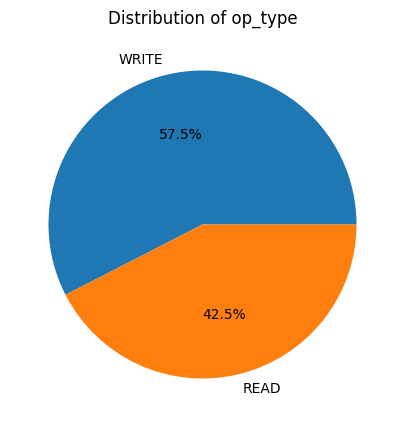

In [14]:
# 1. Overall distribution of op_type
plt.figure(figsize=(5, 5))
thesios_df['op_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of op_type')
plt.ylabel('')
plt.show()

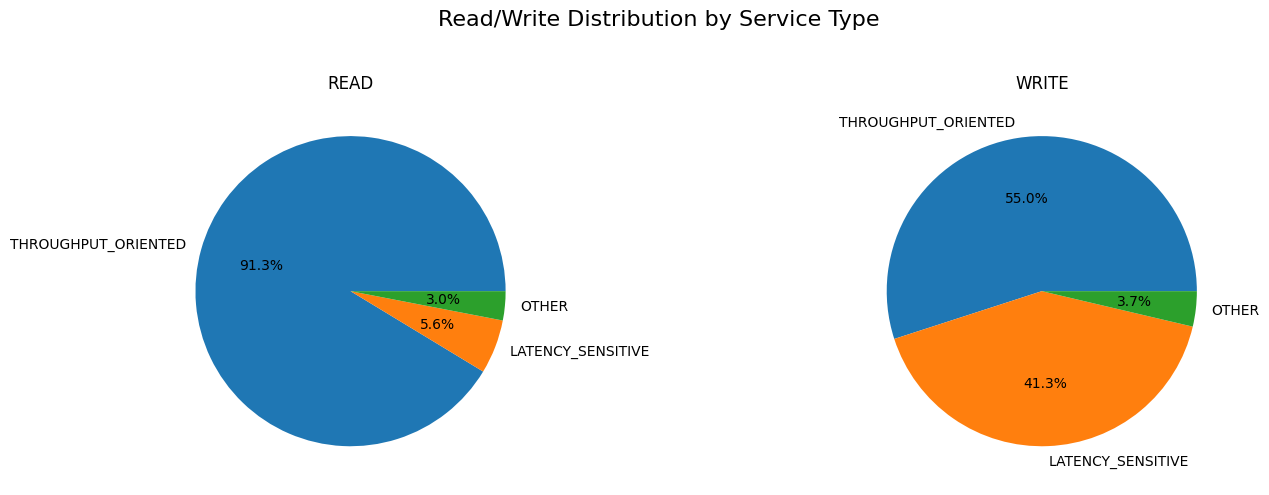

In [15]:
service_types = thesios_df['op_type'].unique()

fig, axes = plt.subplots(1, len(service_types), figsize=(15, 5))  # 1 row, N columns

for i, service_type in enumerate(service_types):
    service_df = thesios_df[thesios_df['op_type'] == service_type]
    
    service_df['service_class'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=axes[i])
    
    axes[i].set_title(service_type)
    axes[i].set_ylabel('')  # Remove y-axis labels for clarity

fig.suptitle('Read/Write Distribution by Service Type', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [16]:
#### Let's see the request size distribution grouped by op_type[read/write]

In [17]:
distribution = request_size_distribution_by_op_type(thesios_df)

# Print the results
for op_type, data in distribution.items():
    print(f"\nOperation Type: {op_type}")
    print(f"Total Count: {data['total_count']} ({data['overall_percentage']:.2f}%)")
    print("------------------------")
    for bucket, stats in data['distribution'].items():
        if stats['count'] > 0:
            print(f"{bucket}: {stats['count']} ({stats['percentage']:.2f}%)")



Operation Type: READ
Total Count: 38565099 (42.45%)
------------------------
0B: 184963 (0.48%)
512B: 155537 (0.40%)
4KB: 4030018 (10.45%)
64KB: 22545688 (58.46%)
512KB: 4223125 (10.95%)
1MB: 7214189 (18.71%)
8MB: 211579 (0.55%)

Operation Type: WRITE
Total Count: 52280233 (57.55%)
------------------------
0B: 15073359 (28.83%)
512B: 7099790 (13.58%)
4KB: 12763867 (24.41%)
64KB: 6794617 (13.00%)
512KB: 2078911 (3.98%)
1MB: 8469689 (16.20%)


### Another observation

In [18]:
filtered_df = thesios_df[(thesios_df['op_type'] == 'WRITE')]

# Check if 'response_io_size_bytes' and 'request_io_size_bytes' are always the same
columns_are_equal = (filtered_df['request_io_size_bytes'] == filtered_df['disk_io_size_bytes']).all()

if columns_are_equal:
    print("For 'WRITE', request IO and disk_io_size_bytes are always the same.")
else:
    print("For 'WRITE', request IO and disk_io_size_bytes are not always the same.")


For 'WRITE', request IO and disk_io_size_bytes are always the same.
